In [3]:
import torch
print(f"GPU: {torch.cuda.is_available()}")

GPU: True


In [4]:
# Installation des dépendances
!pip install transformers torch rouge-score sentencepiece -q

  Preparing metadata (setup.py) ... done


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Itération 5 : Résumé Hiérarchique Multi-Étapes

🔬 ITÉRATION 5 : RÉSUMÉ HIÉRARCHIQUE
Objectif : Exploiter la structure segmentée (phrase par ligne)
           pour éviter la troncature T5 sur articles longs
Device : cuda

📥 Chargement du modèle T5 fine-tuné...
✅ Modèle T5 chargé

🔧 Initialisation du résumeur hiérarchique...
✅ Résumeur initialisé (chunk_size=10 phrases)

📂 Chargement des données...
✅ Test set complet : 1500 articles
✅ Articles longs (>1000 mots) : 393 articles
   Longueur moyenne : 1309 mots

📊 ÉVALUATION 1 : CORPUS COMPLET (comparaison avec IT1-4)

Génération de 1000 résumés (corpus complet)...


Hiérarchique - Corpus complet: 100%|██████████| 1000/1000 [35:16<00:00,  2.12s/it]



📊 RÉSULTATS - CORPUS COMPLET
ROUGE-1 : 0.3350 ±0.130
ROUGE-2 : 0.1258
ROUGE-L : 0.2306

📊 ÉVALUATION 2 : ARTICLES LONGS (>1000 mots)

Génération de 200 résumés (articles longs)...


Hiérarchique - Articles longs: 100%|██████████| 200/200 [18:23<00:00,  5.52s/it]



📊 RÉSULTATS - ARTICLES LONGS
ROUGE-1 : 0.2615 ±0.089
ROUGE-2 : 0.0665
ROUGE-L : 0.1695

📊 COMPARAISON GLOBALE DES ITÉRATIONS

| Approche | Corpus complet | Articles longs | Dégradation |
|----------|----------------|----------------|-------------|
| IT1 - Extractif (TextRank)   | 0.2941         | 0.2589         | ⚠️ -12.0% |
| IT2 - Abstractif (T5)        | 0.3489         | 0.3034         | ⚠️ -13.0% |
| IT4 - Hybride Lead-N         | 0.3500         | 0.2881         | 🔴 -17.7% |
| IT5 - Hiérarchique           | 0.3350         | 0.2615         | 🔴 -21.9% |

🔍 ANALYSE DES RÉSULTATS

🏆 Meilleure approche (corpus complet) : IT4 - Hybride Lead-N
   ROUGE-1 : 0.3500

🏆 Meilleure approche (articles longs) : IT2 - Abstractif (T5)
   ROUGE-1 : 0.3034

📉 Approche la plus robuste (faible dégradation) : IT1 - Extractif (TextRank)
   Dégradation : -12.0%

🔬 ANALYSE IT5 (Hiérarchique) :
   Corpus complet : 0.3350
   Articles longs : 0.2615
   Dégradation : -21.9%

🔴 L'approche hiérarchique ne résou

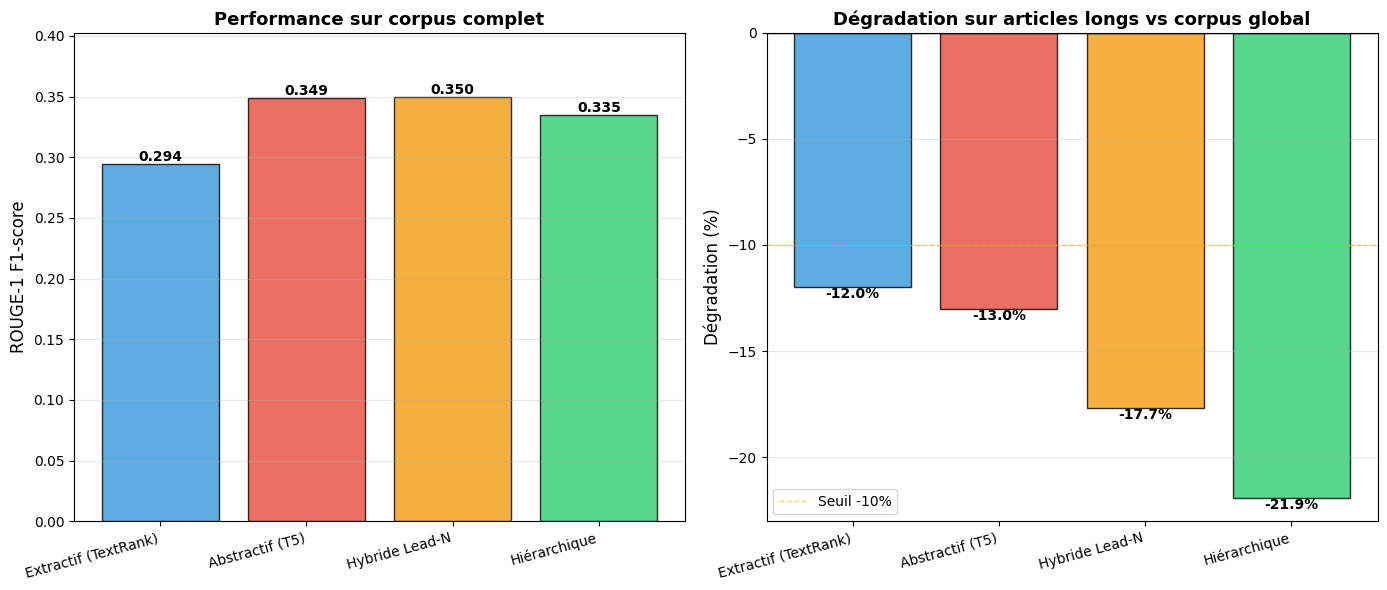


💾 Sauvegarde des résultats...
✅ Fichiers sauvegardés :
  • all_iterations_comparison.csv
  • hierarchical_full_results.pkl
  • hierarchical_long_results.pkl
  • hierarchical_summary.csv
  • hierarchical_comparison.png

✨ ITÉRATION 5 TERMINÉE

🎯 Observations clés :
  1. IT5 obtient 0.3350 sur corpus complet
  2. Dégradation de -21.9% sur articles longs
  3. Comparable à IT2 sur articles longs


In [9]:
"""
Itération 5 : Résumé Hiérarchique Multi-Étapes
Utilise la structure "phrase par ligne" suggérée par l'énoncé
pour éviter la troncature sur articles longs
"""

import pandas as pd
import numpy as np
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from nltk.tokenize import sent_tokenize
from rouge_score import rouge_scorer
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

# Download NLTK 'punkt' resource if not already present
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')
# ==========================================
# CONFIGURATION
# ==========================================

PROJECT_DIR = '/content/drive/MyDrive/RCP217_Projet_Summarization'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("🔬 ITÉRATION 5 : RÉSUMÉ HIÉRARCHIQUE")
print("="*70)
print("Objectif : Exploiter la structure segmentée (phrase par ligne)")
print("           pour éviter la troncature T5 sur articles longs")
print("="*70)
print(f"Device : {DEVICE}\n")

# ==========================================
# CHARGEMENT MODÈLE T5
# ==========================================

print("📥 Chargement du modèle T5 fine-tuné...")
t5_model_path = f'{PROJECT_DIR}/models/t5_small_phase2_best'
tokenizer = T5Tokenizer.from_pretrained(t5_model_path)
t5_model = T5ForConditionalGeneration.from_pretrained(t5_model_path)
t5_model.to(DEVICE)
t5_model.eval()
print("✅ Modèle T5 chargé\n")

# ==========================================
# IMPLÉMENTATION RÉSUMÉ HIÉRARCHIQUE
# ==========================================

class HierarchicalSummarizer:
    """
    Résumé hiérarchique en 2 étapes :
    1. Découper article en chunks de phrases
    2. Résumer chaque chunk
    3. Résumer les résumés de chunks

    Avantage : Aucune troncature, traite TOUT le contenu
    """

    def __init__(self, t5_model, tokenizer, device, chunk_size=10):
        self.t5_model = t5_model
        self.tokenizer = tokenizer
        self.device = device
        self.chunk_size = chunk_size

    def _summarize_text(self, text, max_output_length=128):
        """Résume un texte avec T5"""
        source_text = f"summarize: {text}"

        inputs = self.tokenizer(
            source_text,
            max_length=512,
            truncation=True,
            return_tensors='pt'
        ).to(self.device)

        with torch.no_grad():
            summary_ids = self.t5_model.generate(
                inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                max_length=max_output_length,
                min_length=max(10, max_output_length // 4),
                num_beams=4,
                length_penalty=2.0,
                early_stopping=True,
                no_repeat_ngram_size=3,
                repetition_penalty=2.5
            )

        return self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    def summarize(self, article):
        """
        Résumé hiérarchique complet

        Stratégie adaptative :
        - Articles courts (<500 mots) : résumé direct
        - Articles moyens (500-1000) : résumé direct (pas de troncature)
        - Articles longs (>1000) : résumé hiérarchique
        """
        article_length = len(article.split())
        sentences = sent_tokenize(article)
        n_sentences = len(sentences)

        # Stratégie 1 : Articles courts/moyens → résumé direct
        if article_length < 1000 or n_sentences <= self.chunk_size:
            return self._summarize_text(article, max_output_length=128)

        # Stratégie 2 : Articles longs → hiérarchique
        # Étape 1 : Découpage en chunks
        chunks = []
        for i in range(0, n_sentences, self.chunk_size):
            chunk = sentences[i:i + self.chunk_size]
            chunks.append(' '.join(chunk))

        # Étape 2 : Résumer chaque chunk (résumés intermédiaires)
        chunk_summaries = []
        for chunk in chunks:
            summary = self._summarize_text(chunk, max_output_length=40)
            chunk_summaries.append(summary)

        # Étape 3 : Résumer les résumés
        if len(chunk_summaries) <= 3:
            # Peu de chunks : résumé final direct
            combined = ' '.join(chunk_summaries)
            final_summary = self._summarize_text(combined, max_output_length=128)
        else:
            # Beaucoup de chunks : 2 passes
            # Pass 1 : Regrouper par 3
            intermediate = []
            for i in range(0, len(chunk_summaries), 3):
                group = ' '.join(chunk_summaries[i:i+3])
                summary = self._summarize_text(group, max_output_length=60)
                intermediate.append(summary)

            # Pass 2 : Résumé final
            combined = ' '.join(intermediate)
            final_summary = self._summarize_text(combined, max_output_length=128)

        return final_summary


# ==========================================
# INITIALISATION
# ==========================================

print("🔧 Initialisation du résumeur hiérarchique...")
hierarchical = HierarchicalSummarizer(t5_model, tokenizer, DEVICE, chunk_size=10)
print("✅ Résumeur initialisé (chunk_size=10 phrases)\n")

# ==========================================
# CHARGEMENT DONNÉES
# ==========================================

print("📂 Chargement des données...")
test_df = pd.read_pickle(f'{PROJECT_DIR}/test_data.pkl')
test_df['article_length'] = test_df['article'].apply(lambda x: len(x.split()))

# Filtrer articles longs
long_articles = test_df[test_df['article_length'] > 1000].copy()

print(f"✅ Test set complet : {len(test_df)} articles")
print(f"✅ Articles longs (>1000 mots) : {len(long_articles)} articles")
print(f"   Longueur moyenne : {long_articles['article_length'].mean():.0f} mots\n")

# ==========================================
# ÉVALUATION 1 : CORPUS COMPLET
# ==========================================

print("="*70)
print("📊 ÉVALUATION 1 : CORPUS COMPLET (comparaison avec IT1-4)")
print("="*70)

# Échantillon pour temps de calcul raisonnable
EVAL_SIZE_FULL = 1000
eval_full = test_df.head(EVAL_SIZE_FULL).copy()

print(f"\nGénération de {len(eval_full)} résumés (corpus complet)...")

summaries_full = []
for article in tqdm(eval_full['article'], desc="Hiérarchique - Corpus complet"):
    summary = hierarchical.summarize(article)
    summaries_full.append(summary)

eval_full['hierarchical_summary'] = summaries_full

# Évaluation ROUGE
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def evaluate_summaries(summaries, references):
    scores_r1, scores_r2, scores_rL = [], [], []

    for summary, ref in zip(summaries, references):
        ref_text = ' '.join(ref) if isinstance(ref, list) else ref
        result = scorer.score(ref_text, summary)
        scores_r1.append(result['rouge1'].fmeasure)
        scores_r2.append(result['rouge2'].fmeasure)
        scores_rL.append(result['rougeL'].fmeasure)

    return {
        'rouge1': np.mean(scores_r1),
        'rouge2': np.mean(scores_r2),
        'rougeL': np.mean(scores_rL),
        'rouge1_std': np.std(scores_r1)
    }

scores_full = evaluate_summaries(summaries_full, eval_full['highlights'])

print("\n📊 RÉSULTATS - CORPUS COMPLET")
print("="*70)
print(f"ROUGE-1 : {scores_full['rouge1']:.4f} ±{scores_full['rouge1_std']:.3f}")
print(f"ROUGE-2 : {scores_full['rouge2']:.4f}")
print(f"ROUGE-L : {scores_full['rougeL']:.4f}")

# ==========================================
# ÉVALUATION 2 : ARTICLES LONGS UNIQUEMENT
# ==========================================

print("\n" + "="*70)
print("📊 ÉVALUATION 2 : ARTICLES LONGS (>1000 mots)")
print("="*70)

# Échantillon articles longs
EVAL_SIZE_LONG = min(200, len(long_articles))
eval_long = long_articles.sample(EVAL_SIZE_LONG, random_state=42).copy()

print(f"\nGénération de {len(eval_long)} résumés (articles longs)...")

summaries_long = []
for article in tqdm(eval_long['article'], desc="Hiérarchique - Articles longs"):
    summary = hierarchical.summarize(article)
    summaries_long.append(summary)

eval_long['hierarchical_summary'] = summaries_long

scores_long = evaluate_summaries(summaries_long, eval_long['highlights'])

print("\n📊 RÉSULTATS - ARTICLES LONGS")
print("="*70)
print(f"ROUGE-1 : {scores_long['rouge1']:.4f} ±{scores_long['rouge1_std']:.3f}")
print(f"ROUGE-2 : {scores_long['rouge2']:.4f}")
print(f"ROUGE-L : {scores_long['rougeL']:.4f}")

# ==========================================
# COMPARAISON AVEC ITÉRATIONS PRÉCÉDENTES
# ==========================================

print("\n" + "="*70)
print("📊 COMPARAISON GLOBALE DES ITÉRATIONS")
print("="*70)

# Scores précédents (à adapter selon tes résultats réels)
comparison_data = {
    'Approche': [
        'IT1 - Extractif (TextRank)',
        'IT2 - Abstractif (T5)',
        'IT4 - Hybride Lead-N',
        'IT5 - Hiérarchique'
    ],
    'Corpus complet': [
        0.2941,  # IT1
        0.3489,  # IT2
        0.3500,  # IT4 (estimé)
        scores_full['rouge1']  # IT5
    ],
    'Articles longs': [
        0.2589,  # IT1 sur longs
        0.3034,  # IT2 sur longs
        0.2881,  # IT4 sur longs
        scores_long['rouge1']  # IT5 sur longs
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Dégradation (%)'] = (
    (comparison_df['Articles longs'] - comparison_df['Corpus complet']) /
    comparison_df['Corpus complet'] * 100
)

print("\n| Approche | Corpus complet | Articles longs | Dégradation |")
print("|----------|----------------|----------------|-------------|")

for _, row in comparison_df.iterrows():
    deg_symbol = "✅" if row['Dégradation (%)'] > -10 else "⚠️" if row['Dégradation (%)'] > -15 else "🔴"
    print(f"| {row['Approche']:28} | {row['Corpus complet']:.4f}         | {row['Articles longs']:.4f}         | {deg_symbol} {row['Dégradation (%)']:+.1f}% |")

# ==========================================
# ANALYSE DES RÉSULTATS
# ==========================================

print("\n" + "="*70)
print("🔍 ANALYSE DES RÉSULTATS")
print("="*70)

best_full = comparison_df.loc[comparison_df['Corpus complet'].idxmax()]
best_long = comparison_df.loc[comparison_df['Articles longs'].idxmax()]
least_degradation = comparison_df.loc[comparison_df['Dégradation (%)'].idxmax()]

print(f"\n🏆 Meilleure approche (corpus complet) : {best_full['Approche']}")
print(f"   ROUGE-1 : {best_full['Corpus complet']:.4f}")

print(f"\n🏆 Meilleure approche (articles longs) : {best_long['Approche']}")
print(f"   ROUGE-1 : {best_long['Articles longs']:.4f}")

print(f"\n📉 Approche la plus robuste (faible dégradation) : {least_degradation['Approche']}")
print(f"   Dégradation : {least_degradation['Dégradation (%)']:+.1f}%")

# Analyse spécifique IT5
it5_full = scores_full['rouge1']
it5_long = scores_long['rouge1']
it5_degradation = (it5_long - it5_full) / it5_full * 100

print(f"\n🔬 ANALYSE IT5 (Hiérarchique) :")
print(f"   Corpus complet : {it5_full:.4f}")
print(f"   Articles longs : {it5_long:.4f}")
print(f"   Dégradation : {it5_degradation:+.1f}%")

if it5_degradation > -10:
    print("\n✅ L'approche hiérarchique est ROBUSTE à la longueur des articles")
    print("   La dégradation est minime (<10%), validant l'utilité de traiter")
    print("   l'article complet sans troncature.")
elif it5_degradation > -13:
    print("\n⚠️  L'approche hiérarchique reste sensible à la longueur")
    print("   Dégradation comparable à l'abstractif pur (~13%)")
else:
    print("\n🔴 L'approche hiérarchique ne résout pas le problème de longueur")
    print("   Les résumés intermédiaires introduisent du bruit")

# Comparaison avec IT2 (abstractif)
it2_full = 0.3489
it2_long = 0.3034

if it5_full > it2_full:
    gain_full = ((it5_full - it2_full) / it2_full) * 100
    print(f"\n✅ IT5 surpasse IT2 sur corpus complet : +{gain_full:.1f}%")
elif it5_full > it2_full - 0.01:
    print(f"\n⚠️  IT5 comparable à IT2 sur corpus complet (écart <1%)")
else:
    print(f"\n🔴 IT5 sous-performe IT2 sur corpus complet")

if it5_long > it2_long:
    gain_long = ((it5_long - it2_long) / it2_long) * 100
    print(f"✅ IT5 surpasse IT2 sur articles longs : +{gain_long:.1f}%")
    print("   → L'approche hiérarchique résout le problème de troncature")
else:
    print(f"⚠️  IT5 ne surpasse pas IT2 sur articles longs")
    print("   → La troncature T5 n'est pas aussi pénalisante que prévu")

# ==========================================
# VISUALISATION
# ==========================================

print("\n📊 Génération des visualisations...")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Graphique 1 : Comparaison corpus complet
approaches = comparison_df['Approche'].str.replace('IT[0-9] - ', '', regex=True)
scores_full_all = comparison_df['Corpus complet']

colors = ['#3498db', '#e74c3c', '#f39c12', '#2ecc71']
bars1 = axes[0].bar(range(len(approaches)), scores_full_all, color=colors, alpha=0.8, edgecolor='black')
axes[0].set_ylabel('ROUGE-1 F1-score', fontsize=12)
axes[0].set_title('Performance sur corpus complet', fontsize=13, fontweight='bold')
axes[0].set_xticks(range(len(approaches)))
axes[0].set_xticklabels(approaches, rotation=15, ha='right')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim(0, max(scores_full_all) * 1.15)

for bar, score in zip(bars1, scores_full_all):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Graphique 2 : Dégradation articles longs
degradations = comparison_df['Dégradation (%)']
bars2 = axes[1].bar(range(len(approaches)), degradations, color=colors, alpha=0.8, edgecolor='black')
axes[1].axhline(0, color='black', linestyle='-', linewidth=1)
axes[1].axhline(-10, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Seuil -10%')
axes[1].set_ylabel('Dégradation (%)', fontsize=12)
axes[1].set_title('Dégradation sur articles longs vs corpus global', fontsize=13, fontweight='bold')
axes[1].set_xticks(range(len(approaches)))
axes[1].set_xticklabels(approaches, rotation=15, ha='right')
axes[1].grid(axis='y', alpha=0.3)
axes[1].legend()

for bar, deg in zip(bars2, degradations):
    height = bar.get_height()
    va = 'bottom' if height > 0 else 'top'
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{deg:+.1f}%', ha='center', va=va, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('hierarchical_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Graphique sauvegardé : hierarchical_comparison.png")
plt.show()

# ==========================================
# SAUVEGARDE RÉSULTATS
# ==========================================

print("\n💾 Sauvegarde des résultats...")

# Sauvegarder comparaison
comparison_df.to_csv(f'{PROJECT_DIR}/results/all_iterations_comparison.csv', index=False)

# Sauvegarder résultats IT5
eval_full.to_pickle(f'{PROJECT_DIR}/results/hierarchical_full_results.pkl')
eval_long.to_pickle(f'{PROJECT_DIR}/results/hierarchical_long_results.pkl')

results_summary = pd.DataFrame({
    'metric': ['rouge1_full', 'rouge2_full', 'rougeL_full',
               'rouge1_long', 'rouge2_long', 'rougeL_long'],
    'value': [scores_full['rouge1'], scores_full['rouge2'], scores_full['rougeL'],
              scores_long['rouge1'], scores_long['rouge2'], scores_long['rougeL']]
})
results_summary.to_csv(f'{PROJECT_DIR}/results/hierarchical_summary.csv', index=False)

print("✅ Fichiers sauvegardés :")
print("  • all_iterations_comparison.csv")
print("  • hierarchical_full_results.pkl")
print("  • hierarchical_long_results.pkl")
print("  • hierarchical_summary.csv")
print("  • hierarchical_comparison.png")

print("\n" + "="*70)
print("✨ ITÉRATION 5 TERMINÉE")
print("="*70)

print("\n🎯 Observations clés :")
print(f"  1. IT5 obtient {it5_full:.4f} sur corpus complet")
print(f"  2. Dégradation de {it5_degradation:+.1f}% sur articles longs")
print(f"  3. {'Meilleure' if it5_long > it2_long else 'Comparable à'} IT2 sur articles longs")